In [1]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk

from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.stem.porter import *


import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

## Let's load the dataset

In [2]:
df_file = pd.read_excel('change_of_climate.xlsx')
df_file

,Unnamed: 0,sentiment,message
0,0,-1,@tiniebeany climate change is an interesting h...
1,1,-1,@marie_dunkley arseholes couldn't predict tomo...
2,2,-1,@AngieNBC6 you do understand that climate chan...
3,3,-1,RT @trojan719: Why don't you fucking global wa...
4,4,-1,"RT @realDonaldTrump: It's freezing outside, wh..."
...,...,...,...
43935,51264,1,"Dear @realDonaldTrump,"
43936,51265,1,What will your respective parties do to preven...
43937,51266,2,RT @MikkiL: UN Poll Shows Climate Change Is th...
43938,51267,0,RT @taehbeingextra: i still can$q$t believe th...


## Data exploration

In [3]:
# Sentiment and message columns are the only needed ones for this type of analysis
df_file = df_file[['sentiment', 'message']]

In [4]:
df_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43940 entries, 0 to 43939
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43940 non-null  int64 
 1   message    43939 non-null  object
dtypes: int64(1), object(1)
memory usage: 686.7+ KB


In [5]:
# Count the sentiments
df_file.sentiment.value_counts()

 1    22960
 2     9276
 0     7714
-1     3990
Name: sentiment, dtype: int64

In [6]:
#example of negative sentiments
df_file[df_file.sentiment == -1][0:5]

,sentiment,message
0,-1,@tiniebeany climate change is an interesting h...
1,-1,@marie_dunkley arseholes couldn't predict tomo...
2,-1,@AngieNBC6 you do understand that climate chan...
3,-1,RT @trojan719: Why don't you fucking global wa...
4,-1,"RT @realDonaldTrump: It's freezing outside, wh..."


In [7]:
#example of neutral sentiments
df_file[df_file.sentiment == 0][0:5]

,sentiment,message
7,0,Unamshow awache kujinga na iko global warming ...
8,0,RT @AmericanIndian8: Leonardo DiCaprio's clima...
9,0,National GeographicÃ¢â‚¬â„¢s climate change do...
10,0,@ShellenbergerMD @DrSimEvans @bradplumer @Jiga...
11,0,RT @TheFilmStage: Leonardo DiCaprio's climate ...


In [8]:
#example of positive sentiments
df_file[df_file.sentiment == 1][0:10]

,sentiment,message
96,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...
97,1,Fabulous! Leonardo #DiCaprio's film on #climat...
98,1,RT @Mick_Fanning: Just watched this amazing do...
99,1,#BeforeTheFlood Watch #BeforeTheFlood right he...
100,1,RT @DrDeJarnett: It's vital that the public he...
101,1,"Bangladesh did not cause climate change, so th..."
102,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...
103,1,Now's the time: we need a strong #FTT that wor...
104,1,RT @littoralsociety: The problem with global w...
105,1,RT @NatGeoChannel: One of the easiest ways to ...


In [9]:
# Create a new column with cleaned tweets
# exclude the @ character and the user name 
df_file['cleaned_message'] = df_file['message'].str.replace("@[\w]*", " ")
df_file

,sentiment,message,cleaned_message
0,-1,@tiniebeany climate change is an interesting h...,climate change is an interesting hustle as i...
1,-1,@marie_dunkley arseholes couldn't predict tomo...,arseholes couldn't predict tomorrows weather...
2,-1,@AngieNBC6 you do understand that climate chan...,you do understand that climate change is nat...
3,-1,RT @trojan719: Why don't you fucking global wa...,RT : Why don't you fucking global warming idi...
4,-1,"RT @realDonaldTrump: It's freezing outside, wh...","RT : It's freezing outside, where the hell is..."
...,...,...,...
43935,1,"Dear @realDonaldTrump,","Dear ,"
43936,1,What will your respective parties do to preven...,What will your respective parties do to preven...
43937,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,RT : UN Poll Shows Climate Change Is the Lowe...
43938,0,RT @taehbeingextra: i still can$q$t believe th...,RT : i still can$q$t believe this gif of taeh...


As you have noticed, some special characters are still present in the text. It is better to get rid of them.

In [10]:
def cleaning(df):
    
    # remove short words such as hmm, oh, ha..
    df['cleaned_message'] = df['cleaned_message'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>3]))

    # Replace the special characters
    df['cleaned_message'] = df['cleaned_message'].str.replace("[^a-zA-Z#]", " ")

    # Replace digits/numbers
    df['cleaned_message'] = df['cleaned_message'].str.replace('d', '')

    return df

df_file = cleaning(df_file)
 
df_file


,sentiment,message,cleaned_message
0,-1,@tiniebeany climate change is an interesting h...,climate change interesting hustle global warmi...
1,-1,@marie_dunkley arseholes couldn't predict tomo...,arseholes couln t preict tomorrows weather mon...
2,-1,@AngieNBC6 you do understand that climate chan...,unerstan that climate change natural necessar...
3,-1,RT @trojan719: Why don't you fucking global wa...,on t fucking global warming iiots just away ...
4,-1,"RT @realDonaldTrump: It's freezing outside, wh...",It s freezing outsie where hell global warmi...
...,...,...,...
43935,1,"Dear @realDonaldTrump,",Dear
43936,1,What will your respective parties do to preven...,What will your respective parties prevent clim...
43937,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,Poll Shows Climate Change Lowest Global Concer...
43938,0,RT @taehbeingextra: i still can$q$t believe th...,still can q t believe this taehyung save human...


In [11]:
# To remove the unwanted text patterns from the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

df_file['cleaned_message'] = np.vectorize(remove_pattern)(df_file['cleaned_message'], "@[\w]*")
df_file


,sentiment,message,cleaned_message
0,-1,@tiniebeany climate change is an interesting h...,climate change interesting hustle global warmi...
1,-1,@marie_dunkley arseholes couldn't predict tomo...,arseholes couln t preict tomorrows weather mon...
2,-1,@AngieNBC6 you do understand that climate chan...,unerstan that climate change natural necessar...
3,-1,RT @trojan719: Why don't you fucking global wa...,on t fucking global warming iiots just away ...
4,-1,"RT @realDonaldTrump: It's freezing outside, wh...",It s freezing outsie where hell global warmi...
...,...,...,...
43935,1,"Dear @realDonaldTrump,",Dear
43936,1,What will your respective parties do to preven...,What will your respective parties prevent clim...
43937,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,Poll Shows Climate Change Lowest Global Concer...
43938,0,RT @taehbeingextra: i still can$q$t believe th...,still can q t believe this taehyung save human...


## Tokenization and Stemming

In [12]:
# Splitting string of texts into tokens
tokenized_tweet = df_file['cleaned_message'].apply(lambda x: x.split())

# stripping the suffixes (ing, ent, “s” ..) from a word. 
# look to our presentation. It is shown there!
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet

0        [climat, chang, interest, hustl, global, warm,...
1        [arsehol, couln, t, preict, tomorrow, weather,...
2        [unerstan, that, climat, chang, natur, necessa...
3        [on, t, fuck, global, warm, iiot, just, away, ...
4         [It, s, freez, outsi, where, hell, global, warm]
                               ...                        
43935                                               [dear]
43936    [what, will, your, respect, parti, prevent, cl...
43937    [poll, show, climat, chang, lowest, global, co...
43938    [still, can, q, t, believ, thi, taehyung, save...
43939                                                   []
Name: cleaned_message, Length: 43940, dtype: object

In [13]:
# joining sentences together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df_file['cleaned_message'] = tokenized_tweet
df_file

,sentiment,message,cleaned_message
0,-1,@tiniebeany climate change is an interesting h...,climat chang interest hustl global warm planet...
1,-1,@marie_dunkley arseholes couldn't predict tomo...,arsehol couln t preict tomorrow weather month ...
2,-1,@AngieNBC6 you do understand that climate chan...,unerstan that climat chang natur necessarili c...
3,-1,RT @trojan719: Why don't you fucking global wa...,on t fuck global warm iiot just away real chang
4,-1,"RT @realDonaldTrump: It's freezing outside, wh...",It s freez outsi where hell global warm
...,...,...,...
43935,1,"Dear @realDonaldTrump,",dear
43936,1,What will your respective parties do to preven...,what will your respect parti prevent climat ch...
43937,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,poll show climat chang lowest global concern h...
43938,0,RT @taehbeingextra: i still can$q$t believe th...,still can q t believ thi taehyung save human r...


Looks better!

In [14]:
df_file = df_file[['sentiment','cleaned_message']]

## Visualizing the most common used words 

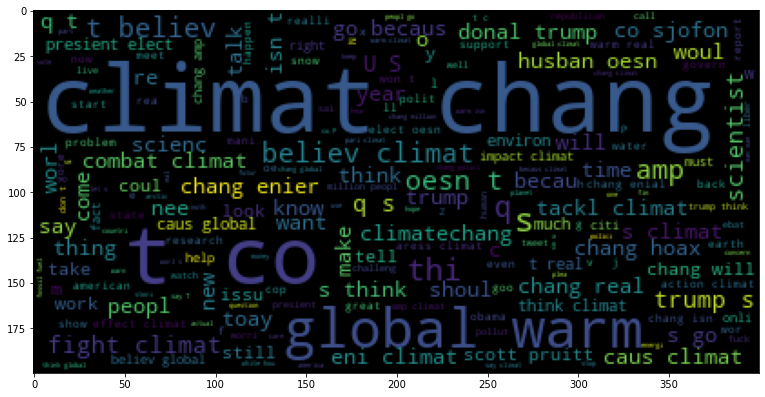

In [15]:
all_words = ' '.join([text for text in df_file['cleaned_message']])
from wordcloud import WordCloud
wordcloud = WordCloud().generate(all_words)

plt.figure(figsize=(13, 7))
plt.imshow(wordcloud)
plt.show()

## Visualizing the most negative used words 

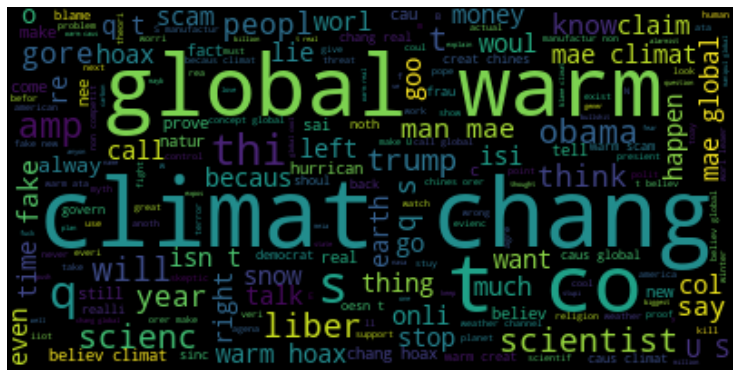

In [16]:
from wordcloud import WordCloud
normal_words =' '.join([text for text in df_file['cleaned_message'][df_file['sentiment'] == -1]])
wordcloud = WordCloud().generate(normal_words)
plt.figure(figsize=(13, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [17]:
# Represent the text into numerical features for the model.
CountVectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# feature matrix for the bag of words
Vectorized = CountVectorizer.fit_transform(df_file['cleaned_message'])

## Term Frequency and Inverse Document Frequency

In [18]:
#Frequency of a word in the entire dataset (See the presentation!)
#TF = (Number of times a term  appears in the dataset)/(Number of terms in the document)
#IDF = log(N/n), where, N is the number of raws and n is the number of raws a term X has appeared in.
#TF-IDF = TF*IDF
#
TfidfVectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
TFID = TfidfVectorizer.fit_transform(df_file['cleaned_message'])
print(TFID)

  (0, 636)	0.6703234494931827
  (0, 953)	0.6339808175647332
  (0, 349)	0.30965019312635433
  (0, 136)	0.1630662630954096
  (0, 157)	0.1620522994481197
  (1, 920)	0.4106924065488395
  (1, 960)	0.4188358369688661
  (1, 389)	0.3428441480890183
  (1, 562)	0.4000341309155465
  (1, 963)	0.2776440196036217
  (1, 901)	0.39352156926629467
  (1, 660)	0.3695551472259805
  (1, 136)	0.07029831446411
  (1, 157)	0.06986119194729207
  (2, 811)	0.4728548104230029
  (2, 411)	0.3947291712477489
  (2, 132)	0.3626171977218626
  (2, 572)	0.4742113880549635
  (2, 927)	0.49225330332532236
  (2, 136)	0.10500696041537214
  (2, 157)	0.10435401578689739
  (3, 708)	0.3152954382125088
  (3, 74)	0.4986388933179171
  (3, 467)	0.32758001219659816
  (3, 420)	0.5143730575316553
  :	:
  (43934, 409)	0.0914301435178064
  (43934, 136)	0.07284083255558284
  (43934, 157)	0.07238790038648985
  (43935, 221)	1.0
  (43936, 620)	0.6504482747879515
  (43936, 671)	0.6961433156766125
  (43936, 349)	0.24393240879056163
  (43936, 136)

## ML model

In [19]:
train = Vectorized
test = Vectorized

# splitting data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(train, df_file['sentiment'], random_state=42, test_size=0.3)
X_train.shape, X_test.shape

((30758, 1000), (13182, 1000))

In [20]:
X_train.dtype

dtype('int64')

In [21]:
from sklearn.neighbors import KNeighborsClassifier
# logistic regression
model1 = LogisticRegression(solver='liblinear', random_state=0)
# knn
model2 = KNeighborsClassifier(n_neighbors=8)

# fit model
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# predict probabilities
pred_prob1 = model1.predict(X_test)
pred_prob2 = model2.predict(X_test)



In [22]:
print("Logistic regression \n\n", classification_report(y_test,pred_prob1))
print("KNN \n", classification_report(y_test,pred_prob2))


Logistic regression 

               precision    recall  f1-score   support

          -1       0.65      0.33      0.44      1174
           0       0.53      0.37      0.43      2323
           1       0.70      0.83      0.76      6904
           2       0.66      0.66      0.66      2781

    accuracy                           0.67     13182
   macro avg       0.63      0.55      0.57     13182
weighted avg       0.66      0.67      0.65     13182

KNN 
               precision    recall  f1-score   support

          -1       0.38      0.18      0.25      1174
           0       0.29      0.71      0.41      2323
           1       0.72      0.50      0.59      6904
           2       0.64      0.48      0.55      2781

    accuracy                           0.50     13182
   macro avg       0.51      0.47      0.45     13182
weighted avg       0.60      0.50      0.52     13182



In [23]:
# predict negative seniments
model1.predict_proba(X_test)[:,-1]


array([0.17538386, 0.10210838, 0.2252288 , ..., 0.03500429, 0.69173076,
       0.58365695])

In [24]:
# predict positive seniments
model1.predict_proba(X_test)[:,2]

array([0.78571005, 0.81544197, 0.66793216, ..., 0.60929455, 0.23159562,
       0.3164567 ])

In [25]:
from sklearn.metrics import accuracy_score

print('Model accuracy score Logistic Regression: {0:0.4f}'. format(accuracy_score(y_test, pred_prob1)))
print('Model accuracy score KNN: {0:0.4f}'. format(accuracy_score(y_test, pred_prob2)))

Model accuracy score Logistic Regression: 0.6663
Model accuracy score KNN: 0.5030


In [26]:
print('Training set score: {:.4f}'.format(model1.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(model1.score(X_test, y_test)))

Training set score: 0.7026
Test set score: 0.6663


In [27]:
print('Training set score: {:.4f}'.format(model2.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(model2.score(X_test, y_test)))

Training set score: 0.6010
Test set score: 0.5030


# Let's do same thing but with different number of trees!
# Excercise

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# knn
model3 = KNeighborsClassifier(n_neighbors= "Choose a number of trees!")

# fit model
model3.fit(X_train, y_train)

# predict probabilities
pred_prob3 = model3.predict(X_test)

In [ ]:
print('Training set score: {:.4f}'.format(model3.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(model3.score(X_test, y_test)))

Training set score: 0.7144
Test set score: 0.5300


## FIN. Merci!